In [5]:
#IMPORT LIBRARIES

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from __future__ import print_function
from IPython.display import clear_output as clc
import cmcrameri.cm as cmc

plt.style.use('default')

# Shallow water equations

\begin{cases}
\dfrac{\partial \mathbf{u}(\mathbf{x},t)}{\partial t} = -\mathbf{u}(\mathbf{x},t) \cdot \nabla \mathbf{u}(\mathbf{x},t) - g \nabla h(\mathbf{x},t) - \nu \Delta^2 \mathbf{u}(\mathbf{x},t) - 2f \times u(\mathbf{x},t) \qquad &\mathrm{in } \ \Omega \times (0,T)
\\[7pt]
\dfrac{\partial h(\mathbf{x},t)}{\partial t} = -H \nabla \cdot \mathbf{u}(\mathbf{x},t) - \nabla \cdot (h(\mathbf{x},t) \mathbf{u}(\mathbf{x},t)) -\nu \Delta^2 h(\mathbf{x},t) + F(\mathbf{x},t) \qquad &\mathrm{in } \ \Omega \times (0,T)
\end{cases}


where $\Omega$ is the domain, $T > 0$ is the final time, $\mathbf{u}: \Omega \times [0,T] \to \mathbb{R}^2$ is the unknown velocity field, $h: \Omega \times [0,T] \to \mathbb{R}$ is the unknown height deviation of the horizontal pressure surface from its mean height, $F: \Omega \times [0,T] \to \mathbb{R}$ is a source term forcing annual and daily periodicity, $g$ is the gravity acceleration, $H$ is the mean height of the horizontal pressure surface, $f$ is the Coriolis coefficient and $\nu$ is the viscosity parameter

# Snapshots loading

In [2]:
# LOAD SNAPSHOTS DATA

from the_well.data import WellDataset

dataset = WellDataset(
    well_base_path = "Data",
    well_dataset_name = "planetswe",
    well_split_name = "train",
    n_steps_input = 1008,
    n_steps_output = 0,
    use_normalization = False
)[0]

In [3]:
# BUILD SNAPSHOTS MATRICES

theta = dataset["space_grid"][:,:,0]
phi = dataset["space_grid"][:,:,1]

ntimes, Lx, Ly, _ = dataset['input_fields'].shape
nheight = nvelocity = Lx * Ly

H = torch.zeros(ntimes, nheight)
Utheta = torch.zeros(ntimes, nvelocity)
Uphi = torch.zeros(ntimes, nvelocity)

H = dataset["input_fields"][:,:,:,0].reshape(ntimes, nheight)
Utheta = dataset["input_fields"][:,:,:,1].reshape(ntimes, nvelocity)
Uphi = dataset["input_fields"][:,:,:,2].reshape(ntimes, nvelocity)

del dataset

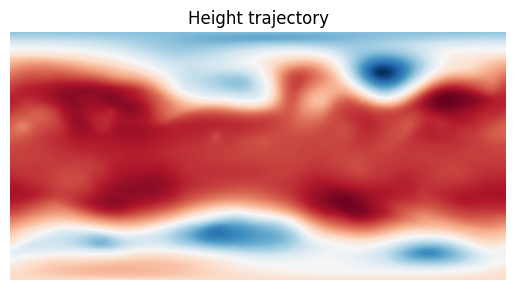

In [6]:
# TRAJECTORY EXAMPLE (PLOT)

from utils.processdata import trajectory

whichtimes = np.arange(0, 50)

def plot_state(u, cmap = "RdBu_r", colorbar = False, shrink = 1.0, extent = None, vmin = None, vmax = None):
    
    fig = plt.imshow(u.reshape(Lx, Ly), extent = extent, cmap = cmap, vmin = vmin, vmax = vmax, origin = 'lower')

    if colorbar:
        plt.colorbar(fig, shrink = shrink)

plot_state_wrapper = lambda u: plot_state(u)

trajectory(H[whichtimes], plot_state_wrapper, title = "Height trajectory", fontsize = 12)

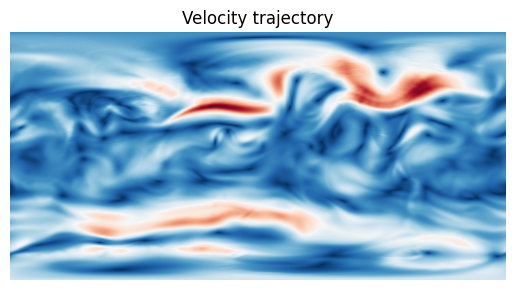

In [7]:
# TRAJECTORY EXAMPLE (PLOT)

whichtimes = np.arange(0, 50)

trajectory((Utheta[whichtimes]**2 + Uphi[whichtimes]**2).sqrt(), plot_state_wrapper, title = "Velocity trajectory", fontsize = 12)

In [8]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed(0)

ntrain = round(0.8 * ntimes)

idx_train = np.random.choice(ntimes, size = ntrain, replace = False)
mask = np.ones(ntimes)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntimes)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

# Height reduction - POD

In [9]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mre, num2p # Error metrics and format

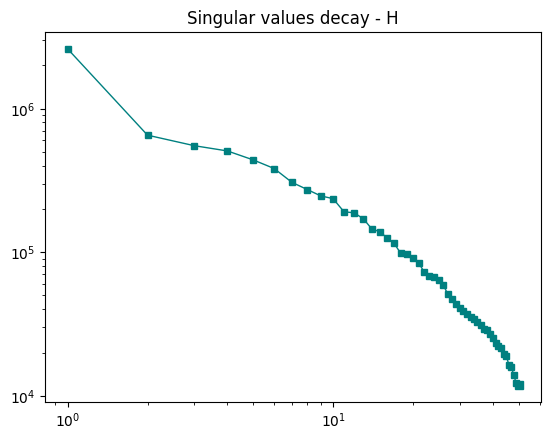

In [10]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR U

from sklearn.utils.extmath import randomized_svd

kheight = 50 # Number of POD modes

W, S, V = randomized_svd(H[idx_train].numpy(), n_components = kheight)

teal = sns.light_palette("teal", 15)
plt.plot([i for i in range(1, kheight + 1)], S, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kheight, S[kheight-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay - H");

H_POD = H @ V.transpose()

In [11]:
# SCALING

from sklearn.preprocessing import MinMaxScaler

scalerH = MinMaxScaler()
scalerH = scalerH.fit(H_POD[idx_train])
H_POD = torch.from_numpy(scalerH.transform(H_POD).reshape(ntimes, kheight))

In [12]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

print("Mean relative POD reconstruction error on H: %s" % num2p(mre(H[idx_test], torch.from_numpy((H[idx_test].numpy() @ V.transpose() @ V).reshape(ntest, nheight)))))

Mean relative POD reconstruction error on H: 1.34%


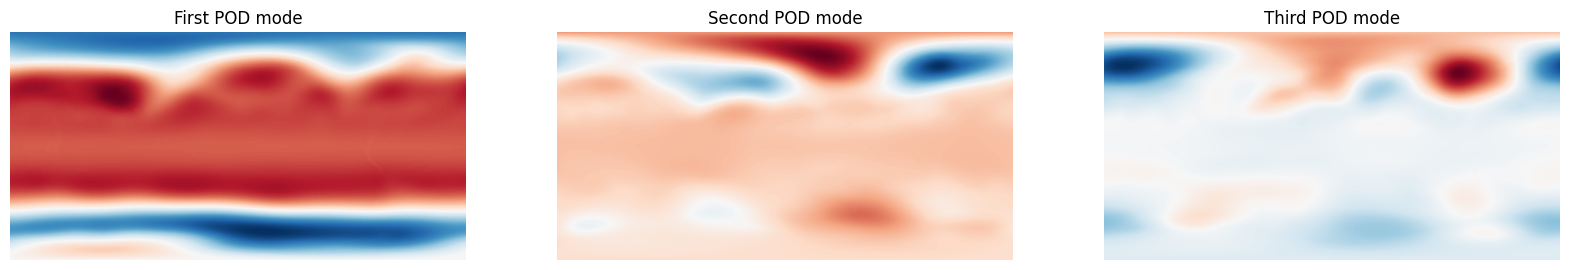

In [13]:
# POD MODES (PLOT)

plotlist = [V[0], V[1], V[2]]

from utils.processdata import multiplot

multiplot(plotlist, plot_state_wrapper, titles = ("First POD mode", "Second POD mode", "Third POD mode"), fontsize = 12, figsize = (20, 5))

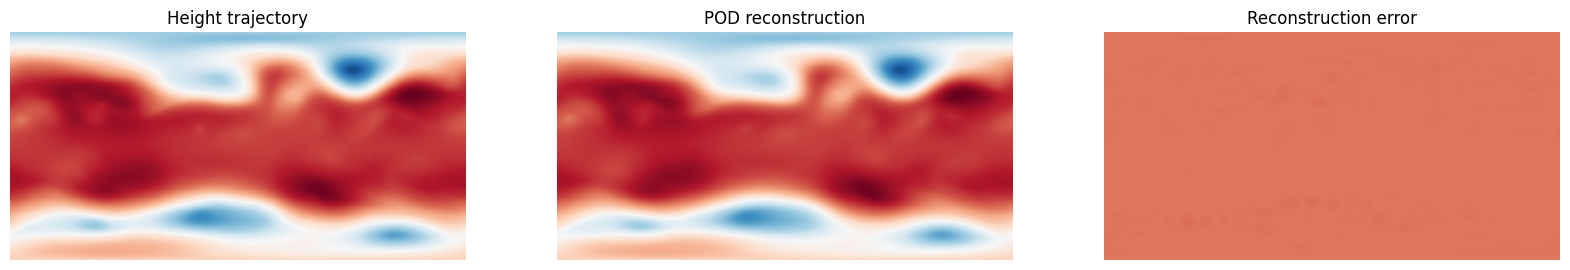

In [15]:
# FOM vs POD RECONSTRUCTION (PLOTS)

from utils.processdata import trajectories

whichtimes = torch.arange(0, 50)
                 
plotlist = [H[whichtimes],
            torch.from_numpy((H[whichtimes].numpy() @ V.transpose() @ V)),
            np.sqrt((H[whichtimes] - torch.from_numpy((H[whichtimes].numpy() @ V.transpose() @ V)))**2)]

vmin = min(plotlist[i].min() for i in range(len(plotlist)))
vmax = max(plotlist[i].max() for i in range(len(plotlist)))

plot_state_wrapper = lambda u: plot_state(u, vmin = vmin, vmax = vmax)

trajectories(plotlist, plot_state_wrapper, titles = ("Height trajectory", "POD reconstruction", "Reconstruction error"), fontsize = 12, figsize = (20, 5))

# Velocity reduction - POD

In [16]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mre, num2p # Error metrics and format

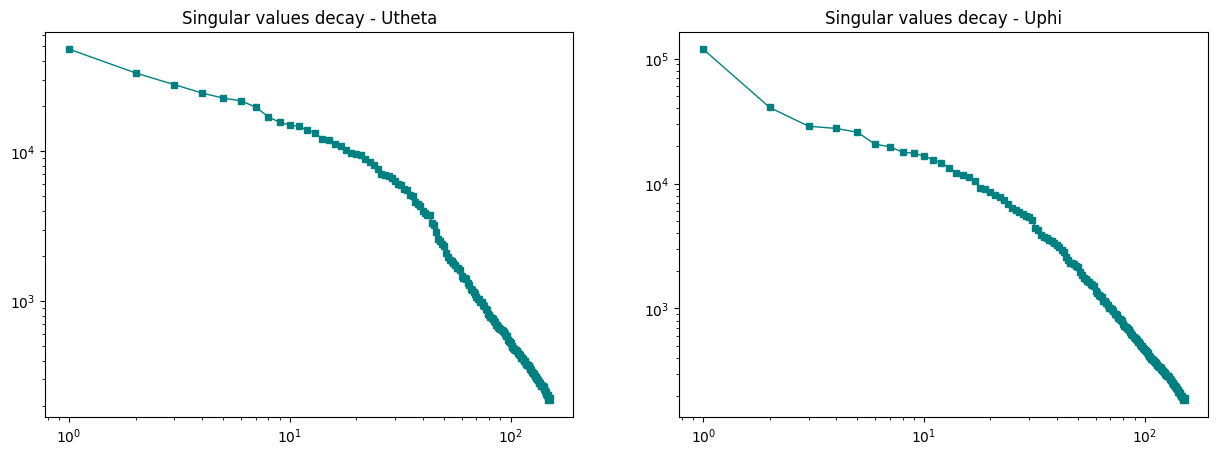

In [17]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR U

from sklearn.utils.extmath import randomized_svd

kvelocity = 150 # Number of POD modes

Wtheta, Stheta, Vtheta = randomized_svd(Utheta[idx_train].numpy(), n_components = kvelocity)

Wphi, Sphi, Vphi = randomized_svd(Uphi[idx_train].numpy(), n_components = kvelocity)

teal = sns.light_palette("teal", 15)
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot([i for i in range(1, kvelocity + 1)], Stheta, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kvelocity, Stheta[kvelocity-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay - Utheta");

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1, kvelocity + 1)], Sphi, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kvelocity, Sphi[kvelocity-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay - Uphi");

Utheta_POD = Utheta @ Vtheta.transpose()
Uphi_POD = Uphi @ Vphi.transpose()

In [18]:
# SCALING

from sklearn.preprocessing import MinMaxScaler

scalerUtheta = MinMaxScaler()
scalerUtheta = scalerUtheta.fit(Utheta_POD[idx_train])
Utheta_POD = torch.from_numpy(scalerUtheta.transform(Utheta_POD).reshape(ntimes, kvelocity))

scalerUphi = MinMaxScaler()
scalerUphi = scalerUphi.fit(Uphi_POD[idx_train])
Uphi_POD = torch.from_numpy(scalerUphi.transform(Uphi_POD).reshape(ntimes, kvelocity))

In [19]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

print("Mean relative POD reconstruction error on Utheta: %s" % num2p(mre(Utheta[idx_test], torch.from_numpy((Utheta[idx_test].numpy() @ Vtheta.transpose() @ Vtheta).reshape(ntest, nvelocity)))))
print("Mean relative POD reconstruction error on Uphi: %s" % num2p(mre(Uphi[idx_test], torch.from_numpy((Uphi[idx_test].numpy() @ Vphi.transpose() @ Vphi).reshape(ntest, nvelocity)))))

Mean relative POD reconstruction error on Utheta: 1.71%
Mean relative POD reconstruction error on Uphi: 0.91%


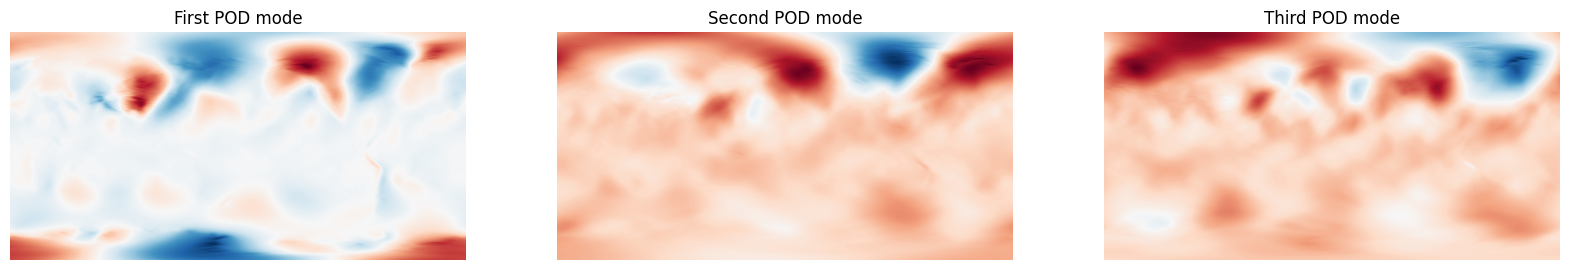

In [20]:
# POD MODES (PLOT)

plotlist = [Vtheta[0], Vtheta[1], Vtheta[2]]

from utils.processdata import multiplot

plot_state_wrapper = lambda u: plot_state(u)

multiplot(plotlist, plot_state_wrapper, titles = ("First POD mode", "Second POD mode", "Third POD mode"), fontsize = 12, figsize = (20, 5))

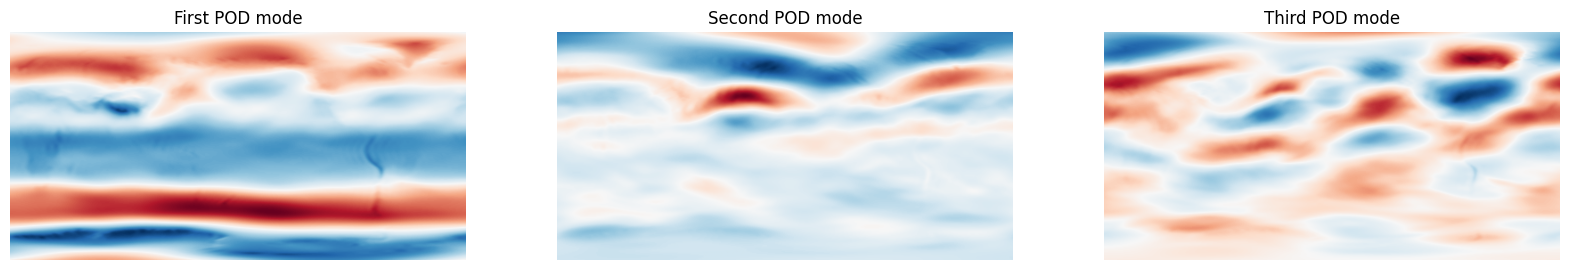

In [21]:
# POD MODES (PLOT)

plotlist = [Vphi[0], Vphi[1], Vphi[2]]

from utils.processdata import multiplot

multiplot(plotlist, plot_state_wrapper, titles = ("First POD mode", "Second POD mode", "Third POD mode"), fontsize = 12, figsize = (20, 5))

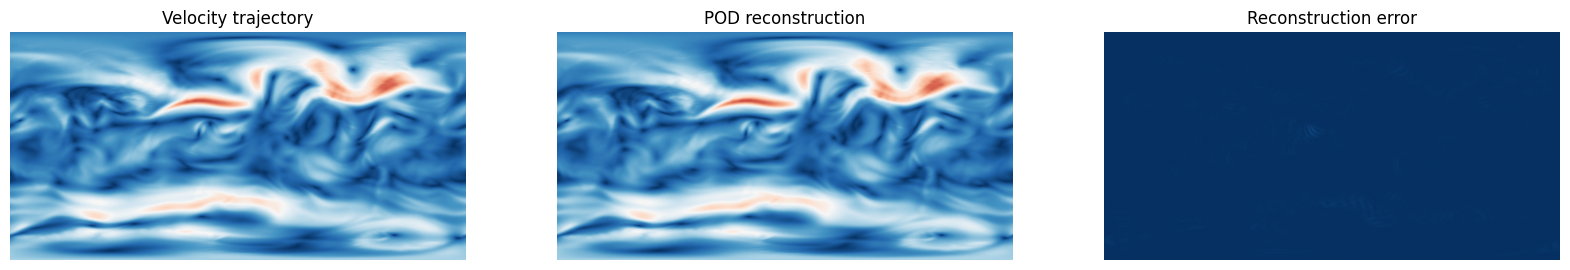

In [22]:
# FOM vs POD RECONSTRUCTION (PLOTS)

whichtimes = torch.arange(0, 50)

plotlist = [(Utheta[whichtimes]**2 + Uphi[whichtimes]**2).sqrt(),
            (torch.from_numpy((Utheta[whichtimes].numpy() @ Vtheta.transpose() @ Vtheta))**2 + torch.from_numpy((Uphi[whichtimes].numpy() @ Vphi.transpose() @ Vphi))**2).sqrt(),
            np.sqrt((Utheta[whichtimes] - torch.from_numpy((Utheta[whichtimes].numpy() @ Vtheta.transpose() @ Vtheta)))**2 + (Uphi[whichtimes] - torch.from_numpy((Uphi[whichtimes].numpy() @ Vphi.transpose() @ Vphi)))**2)]

vmin = min(plotlist[i].min() for i in range(len(plotlist)))
vmax = max(plotlist[i].max() for i in range(len(plotlist)))

plot_state_wrapper = lambda u: plot_state(u, vmin = vmin, vmax = vmax)

trajectories(plotlist, plot_state_wrapper, titles = ("Velocity trajectory", "POD reconstruction", "Reconstruction error"), fontsize = 12, figsize = (20, 5))

# SHRED-ROM

## Height prediction from height sensors

In [135]:
# EXTRACT SENSORS DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

nsensors = 3
sensors_coordinates = np.vstack((np.random.choice(Lx, size = nsensors, replace = True), np.random.choice(Ly, size = nsensors, replace = True))).T

sensors_data = H.reshape(ntimes, Lx, Ly)[:,sensors_coordinates[:,0], sensors_coordinates[:,1]]

In [23]:
# LOAD SENSORS DATA

nsensors = 3
sensors_coordinates = torch.load('Data/sensors_coordinates.pt', weights_only = False)

sensors_data = H.reshape(ntimes, Lx, Ly)[:,sensors_coordinates[:,0], sensors_coordinates[:,1]]

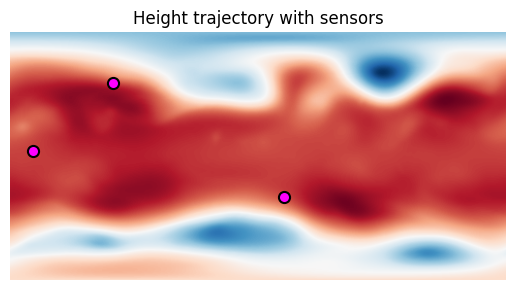

In [24]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_sensors(ut, sensors_coordinates, title = None):
    """
    Velocity trajectory with sensors
    Input: velocity trajectory with dimension (ntimes, nvelocity) and sensors coordinates with dimension (2 * nsensors)
    """
    
    for i in range(ut.shape[0]):
        plot_state(ut[i])
        for k in np.arange(nsensors):
            plt.plot(sensors_coordinates[k,1], sensors_coordinates[k,0], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtimes = np.arange(0, 50)

trajectory_with_sensors(H[whichtimes], sensors_coordinates, title = "Height trajectory with sensors")

In [25]:
# BUILD INPUT AND OUTPUT DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 100

data_in = Padding(sensors_data.unsqueeze(0), lag).to(device)

train_data_in = data_in[idx_train]
valid_data_in = data_in[idx_valid]
test_data_in = data_in[idx_test]

train_data_out = H_POD[idx_train].to(device)
valid_data_out = H_POD[idx_valid].to(device)
test_data_out = H_POD[idx_test].to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [ ]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(nsensors, kheight, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 1000, lr = 1e-3, verbose = True, patience = 100)

In [28]:
# SHRED LOADING

from utils.models import SHRED

shred = SHRED(nsensors, kheight, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load('NN/PlanetSWE_shred_height.pt', weights_only = True));

In [29]:
# SHRED PREDICTIONS AND ERRORS

shred.freeze()

train_data_out_hat = shred(train_data_in).cpu()
valid_data_out_hat = shred(valid_data_in).cpu()
test_data_out_hat = shred(test_data_in).cpu()

H_hat = torch.zeros(ntimes, nheight)

H_hat[idx_train] = torch.from_numpy(scalerH.inverse_transform(train_data_out_hat)).float() @ V
H_hat[idx_valid] = torch.from_numpy(scalerH.inverse_transform(valid_data_out_hat)).float() @ V
H_hat[idx_test] = torch.from_numpy(scalerH.inverse_transform(test_data_out_hat)).float() @ V

print("Mean relative SHRED prediction error on H - training set: %s" % num2p(mre(H[idx_train], H_hat[idx_train])))
print("Mean relative SHRED prediction error on H - validation set: %s" % num2p(mre(H[idx_valid], H_hat[idx_valid])))
print("Mean relative SHRED prediction error on H - test set: %s" % num2p(mre(H[idx_test], H_hat[idx_test])))

Mean relative SHRED prediction error on H - training set: 3.03%
Mean relative SHRED prediction error on H - validation set: 3.13%
Mean relative SHRED prediction error on H - test set: 3.14%


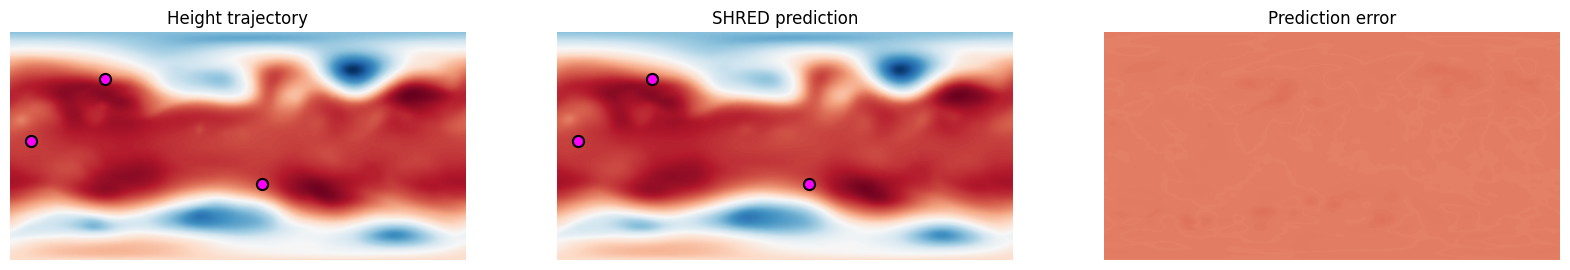

In [30]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectories_with_sensors(uts, sensors_coordinates, titles = None):
    """
    Trajectories with sensors
    Input: list of trajectories with dimension (ntimes, nvelocity) and sensor coordinates
    """
    
    for i in range(uts[0].shape[0]):
    
        vmin = min(uts[j][i].min() for j in range(len(plotlist)))
        vmax = max(uts[j][i].max() for j in range(len(plotlist)))
    
        plt.figure(figsize = (20, 5))
        for j in range(len(uts)):
            plt.subplot(1, len(uts), j+1)
            plot_state(uts[j][i], vmin = vmin, vmax = vmax)
            if j < len(uts)-1:
                for k in np.arange(nsensors):
                    plt.plot(sensors_coordinates[k,1], sensors_coordinates[k,0], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)
        
            plt.title(titles[j], fontsize = 12)
            plt.axis('off')
        
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtimes = np.arange(0, 50)

plotlist = [H[whichtimes], H_hat[whichtimes], ((H[whichtimes] - H_hat[whichtimes])**2).sqrt()]

trajectories_with_sensors(plotlist, sensors_coordinates, titles = ("Height trajectory", "SHRED prediction", "Prediction error"))

## Velocity prediction from height sensors - fixed sensors

In [ ]:
# EXTRACT SENSORS DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

nsensors = 3
sensors_coordinates = np.vstack((np.random.choice(Lx, size = nsensors, replace = True), np.random.choice(Ly, size = nsensors, replace = True))).T

sensors_data = H.reshape(ntimes, Lx, Ly)[:,sensors_coordinates[:,0], sensors_coordinates[:,1]]

In [31]:
# LOAD SENSORS DATA

nsensors = 3
sensors_coordinates = torch.load('Data/sensors_coordinates.pt', weights_only = False)

sensors_data = H.reshape(ntimes, Lx, Ly)[:,sensors_coordinates[:,0], sensors_coordinates[:,1]]

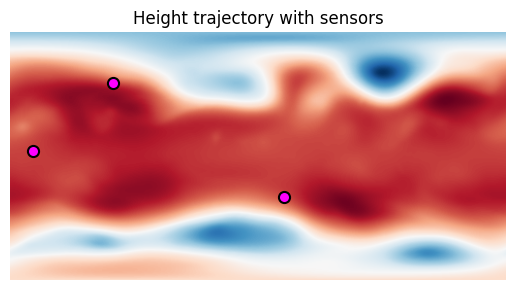

In [32]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_sensors(ut, sensors_coordinates, title = None):
    """
    Velocity trajectory with sensors
    Input: velocity trajectory with dimension (ntimes, nvelocity) and sensors coordinates with dimension (2 * nsensors)
    """
    
    for i in range(ut.shape[0]):
        plot_state(ut[i])
        for k in np.arange(nsensors):
            plt.plot(sensors_coordinates[k,1], sensors_coordinates[k,0], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtimes = np.arange(0, 50)

trajectory_with_sensors(H[whichtimes], sensors_coordinates, title = "Height trajectory with sensors")

In [33]:
# BUILD INPUT AND OUTPUT DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 100

data_in = Padding(sensors_data.unsqueeze(0), lag).to(device)

train_data_in = data_in[idx_train]
valid_data_in = data_in[idx_valid]
test_data_in = data_in[idx_test]

train_data_out = torch.cat((Utheta_POD[idx_train], Uphi_POD[idx_train]), 1).to(device)
valid_data_out = torch.cat((Utheta_POD[idx_valid], Uphi_POD[idx_valid]), 1).to(device)
test_data_out = torch.cat((Utheta_POD[idx_test], Uphi_POD[idx_test]), 1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [ ]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(nsensors, 2*kvelocity, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 1000, lr = 1e-3, verbose = True, patience = 100)

In [34]:
# SHRED LOADING

from utils.models import SHRED

shred = SHRED(nsensors, 2*kvelocity, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load('NN/PlanetSWE_shred_velocity.pt', weights_only = True));

In [35]:
# SHRED PREDICTIONS AND ERRORS

shred.freeze()

train_data_out_hat = shred(train_data_in).cpu()
valid_data_out_hat = shred(valid_data_in).cpu()
test_data_out_hat = shred(test_data_in).cpu()

Utheta_hat = torch.zeros(ntimes, nvelocity)
Uphi_hat = torch.zeros(ntimes, nvelocity)

Utheta_hat[idx_train] = torch.from_numpy(scalerUtheta.inverse_transform(train_data_out_hat[:,:kvelocity])).float() @ Vtheta
Utheta_hat[idx_valid] = torch.from_numpy(scalerUtheta.inverse_transform(valid_data_out_hat[:,:kvelocity])).float() @ Vtheta
Utheta_hat[idx_test] = torch.from_numpy(scalerUtheta.inverse_transform(test_data_out_hat[:,:kvelocity])).float() @ Vtheta

Uphi_hat[idx_train] = torch.from_numpy(scalerUphi.inverse_transform(train_data_out_hat[:,kvelocity:])).float() @ Vphi
Uphi_hat[idx_valid] = torch.from_numpy(scalerUphi.inverse_transform(valid_data_out_hat[:,kvelocity:])).float() @ Vphi
Uphi_hat[idx_test] = torch.from_numpy(scalerUphi.inverse_transform(test_data_out_hat[:,kvelocity:])).float() @ Vphi

print("Mean relative SHRED prediction error on Utheta - training set: %s" % num2p(mre(Utheta[idx_train], Utheta_hat[idx_train])))
print("Mean relative SHRED prediction error on Utheta - validation set: %s" % num2p(mre(Utheta[idx_valid], Utheta_hat[idx_valid])))
print("Mean relative SHRED prediction error on Utheta - test set: %s" % num2p(mre(Utheta[idx_test], Utheta_hat[idx_test])))
print("")
print("Mean relative SHRED prediction error on Uphi - training set: %s" % num2p(mre(Uphi[idx_train], Uphi_hat[idx_train])))
print("Mean relative SHRED prediction error on Uphi - validation set: %s" % num2p(mre(Uphi[idx_valid], Uphi_hat[idx_valid])))
print("Mean relative SHRED prediction error on Uphi - test set: %s" % num2p(mre(Uphi[idx_test], Uphi_hat[idx_test])))

Mean relative SHRED prediction error on Utheta - training set: 8.80%
Mean relative SHRED prediction error on Utheta - validation set: 9.84%
Mean relative SHRED prediction error on Utheta - test set: 9.59%

Mean relative SHRED prediction error on Uphi - training set: 5.39%
Mean relative SHRED prediction error on Uphi - validation set: 6.10%
Mean relative SHRED prediction error on Uphi - test set: 5.90%


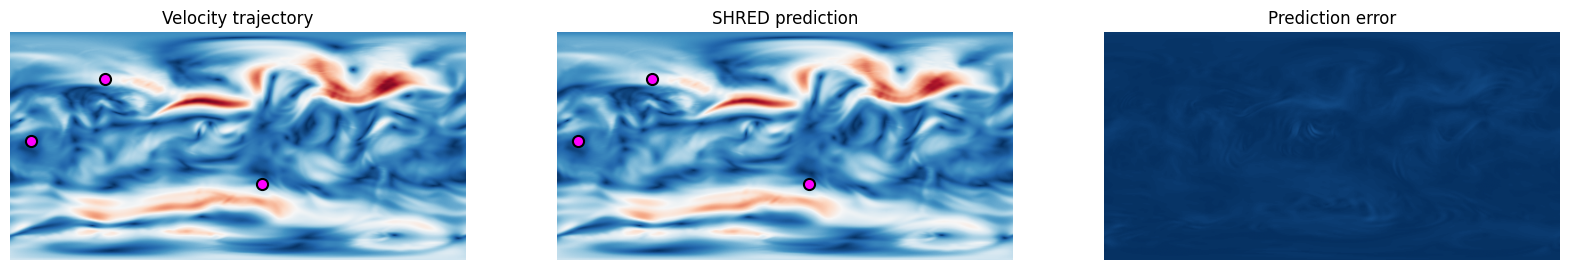

In [36]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectories_with_sensors(uts, sensors_coordinates, titles = None):
    """
    Trajectories with sensors
    Input: list of trajectories with dimension (ntimes, nvelocity) and sensor coordinates
    """

    for i in range(uts[0].shape[0]):
    
        vmin = min(uts[j][i].min() for j in range(len(plotlist)))
        vmax = max(uts[j][i].max() for j in range(len(plotlist)))
    
        plt.figure(figsize = (20, 5))
        for j in range(len(uts)):
            plt.subplot(1, len(uts), j+1)
            plot_state(uts[j][i], vmin = vmin, vmax = vmax)
            if j < len(uts)-1:
                for k in np.arange(nsensors):
                    plt.plot(sensors_coordinates[k,1], sensors_coordinates[k,0], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)
        
            plt.title(titles[j], fontsize = 12)
            plt.axis('off')
        
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtimes = np.arange(0, 50)

plotlist = [(Utheta[whichtimes]**2 + Uphi[whichtimes]**2).sqrt(), (Utheta_hat[whichtimes]**2 + Uphi_hat[whichtimes]**2).sqrt(), ((Utheta[whichtimes] - Utheta_hat[whichtimes])**2 + (Uphi[whichtimes] - Uphi_hat[whichtimes])**2).sqrt()]

trajectories_with_sensors(plotlist, sensors_coordinates, titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"))

## Velocity prediction from height sensors - moving sensor

In [50]:
# EXTRACT SENSORS COORDINATES (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

from scipy.interpolate import griddata

nsensors = 1
sensor_coordinates = torch.zeros(ntimes, 2)
coordinates = np.column_stack((theta.ravel(), phi.ravel()))
dt = 3600
r = 6.37122e6

for i in range(450, ntimes):
    if i == 0:
        sensor_coordinates[i, 0] = theta[Lx//4, Ly//2]
        sensor_coordinates[i, 1] = phi[Lx//2, Ly//2]
    else:
        sensor_coordinates[i, 0] = sensor_coordinates[i-1, 0] + dt / r * griddata(coordinates, Utheta[i-1], sensor_coordinates[i-1], method = 'linear')
        sensor_coordinates[i, 1] = sensor_coordinates[i-1, 1] + dt / r / sensor_coordinates[i-1, 0].sin() * griddata(coordinates, Uphi[i-1], sensor_coordinates[i-1], method = 'linear')

        if sensor_coordinates[i, 0] < theta.min():
            sensor_coordinates[i, 0] += np.pi
            sensor_coordinates[i, 0] = min(sensor_coordinates[i, 0], theta.max())
        if sensor_coordinates[i, 0] > theta.max():
            sensor_coordinates[i, 0] -= np.pi
            sensor_coordinates[i, 0] = max(sensor_coordinates[i, 0], theta.min())
        if sensor_coordinates[i, 1] < phi.min():
            sensor_coordinates[i, 1] += 2*np.pi
            sensor_coordinates[i, 1] = min(sensor_coordinates[i, 1], phi.max())
        if sensor_coordinates[i, 1] > phi.max():
            sensor_coordinates[i, 1] -= 2*np.pi
            sensor_coordinates[i, 1] = max(sensor_coordinates[i, 1], phi.min())
    
    print(f'Time {i}')
    print(f'Location ({sensor_coordinates[i, 0]},{sensor_coordinates[i, 1]})')
    clc(wait=True)

print('Moving sensor coordinates generated')


Moving sensor coordinates generated


In [46]:
# LOAD SENSORS COORDINATES

nsensors = 1
sensor_coordinates = torch.zeros(ntimes, 2)
sensor_coordinates = torch.load('Data/movingsensor_coordinates.pt', weights_only = False)

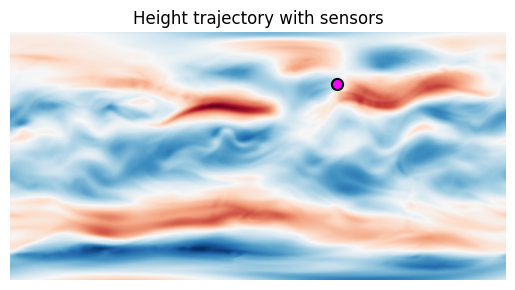

In [ ]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_sensors(ut, sensor_coordinates, title = None):
    """
    Velocity trajectory with sensors
    Input: velocity trajectory with dimension (ntimes, nvelocity) and sensors coordinates with dimension (2 * nsensors)
    """
    
    for i in range(ut.shape[0]):
        plot_state(ut[i], extent = [0, 2*np.pi, 0, np.pi])
        plt.plot(sensor_coordinates[i,1], sensor_coordinates[i,0], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        plt.pause(1)
        clc(wait=True)

whichtimes = np.arange(0, 50)

trajectory_with_sensors(Uphi[whichtimes], sensor_coordinates[whichtimes], title = "Height trajectory with sensors")

In [47]:
# BUILD INPUT AND OUTPUT DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 100

data_in = Padding(sensor_coordinates.unsqueeze(0), lag).to(device)

train_data_in = data_in[idx_train]
valid_data_in = data_in[idx_valid]
test_data_in = data_in[idx_test]

train_data_out = torch.cat((Utheta_POD[idx_train], Uphi_POD[idx_train]), 1).to(device)
valid_data_out = torch.cat((Utheta_POD[idx_valid], Uphi_POD[idx_valid]), 1).to(device)
test_data_out = torch.cat((Utheta_POD[idx_test], Uphi_POD[idx_test]), 1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [ ]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(2*nsensors, 2*kvelocity, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 1000, lr = 1e-3, verbose = True, patience = 100)

In [51]:
# SHRED LOADING

from utils.models import SHRED

shred = SHRED(2*nsensors, 2*kvelocity, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load('NN/PlanetSWE_shred_velocity_movingsensor.pt', weights_only = True));

In [52]:
# SHRED PREDICTIONS AND ERRORS

shred.freeze()

train_data_out_hat = shred(train_data_in).cpu()
valid_data_out_hat = shred(valid_data_in).cpu()
test_data_out_hat = shred(test_data_in).cpu()

Utheta_hat = torch.zeros(ntimes, nvelocity)
Uphi_hat = torch.zeros(ntimes, nvelocity)

Utheta_hat[idx_train] = torch.from_numpy(scalerUtheta.inverse_transform(train_data_out_hat[:,:kvelocity])).float() @ Vtheta
Utheta_hat[idx_valid] = torch.from_numpy(scalerUtheta.inverse_transform(valid_data_out_hat[:,:kvelocity])).float() @ Vtheta
Utheta_hat[idx_test] = torch.from_numpy(scalerUtheta.inverse_transform(test_data_out_hat[:,:kvelocity])).float() @ Vtheta

Uphi_hat[idx_train] = torch.from_numpy(scalerUphi.inverse_transform(train_data_out_hat[:,kvelocity:])).float() @ Vphi
Uphi_hat[idx_valid] = torch.from_numpy(scalerUphi.inverse_transform(valid_data_out_hat[:,kvelocity:])).float() @ Vphi
Uphi_hat[idx_test] = torch.from_numpy(scalerUphi.inverse_transform(test_data_out_hat[:,kvelocity:])).float() @ Vphi

print("Mean relative SHRED prediction error on Utheta - training set: %s" % num2p(mre(Utheta[idx_train], Utheta_hat[idx_train])))
print("Mean relative SHRED prediction error on Utheta - validation set: %s" % num2p(mre(Utheta[idx_valid], Utheta_hat[idx_valid])))
print("Mean relative SHRED prediction error on Utheta - test set: %s" % num2p(mre(Utheta[idx_test], Utheta_hat[idx_test])))
print("")
print("Mean relative SHRED prediction error on Uphi - training set: %s" % num2p(mre(Uphi[idx_train], Uphi_hat[idx_train])))
print("Mean relative SHRED prediction error on Uphi - validation set: %s" % num2p(mre(Uphi[idx_valid], Uphi_hat[idx_valid])))
print("Mean relative SHRED prediction error on Uphi - test set: %s" % num2p(mre(Uphi[idx_test], Uphi_hat[idx_test])))

Mean relative SHRED prediction error on Utheta - training set: 6.56%
Mean relative SHRED prediction error on Utheta - validation set: 7.46%
Mean relative SHRED prediction error on Utheta - test set: 7.43%

Mean relative SHRED prediction error on Uphi - training set: 4.29%
Mean relative SHRED prediction error on Uphi - validation set: 4.94%
Mean relative SHRED prediction error on Uphi - test set: 4.80%


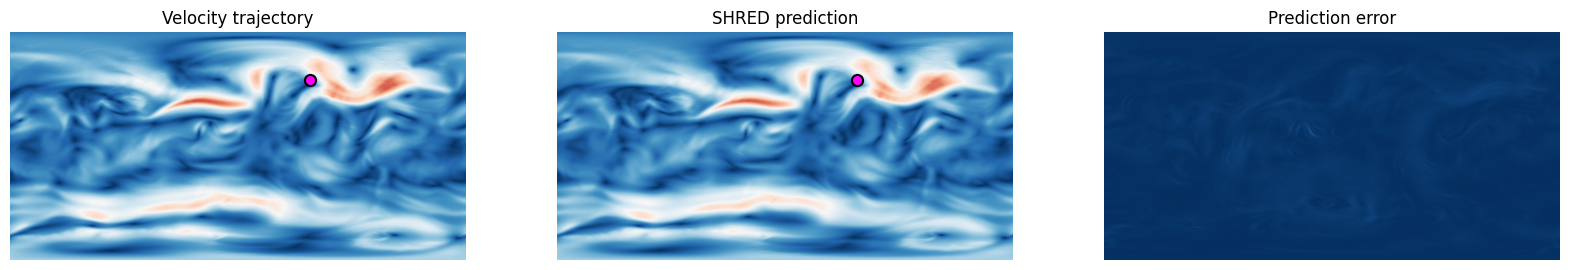

In [53]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectories_with_sensors(uts, sensor_coordinates, titles = None):
    """
    Trajectories with sensors
    Input: list of trajectories with dimension (ntimes, nvelocity) and sensor coordinates
    """
    
    vmin = min(plotlist[i].min() for i in range(len(plotlist)))
    vmax = max(plotlist[i].max() for i in range(len(plotlist)))
    
    for i in range(uts[0].shape[0]):
    
        plt.figure(figsize = (20, 5))
        for j in range(len(uts)):
            plt.subplot(1, len(uts), j+1)
            plot_state(uts[j][i], extent = [0, 2*np.pi, 0, np.pi], vmin = vmin, vmax = vmax)
            if j < len(uts)-1:
                plt.plot(sensor_coordinates[i,1], sensor_coordinates[i,0], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)       
            plt.title(titles[j], fontsize = 12)
            plt.axis('off')
        
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtimes = np.arange(0, 50)

plotlist = [(Utheta[whichtimes]**2 + Uphi[whichtimes]**2).sqrt(), (Utheta_hat[whichtimes]**2 + Uphi_hat[whichtimes]**2).sqrt(), ((Utheta[whichtimes] - Utheta_hat[whichtimes])**2 + (Uphi[whichtimes] - Uphi_hat[whichtimes])**2).sqrt()]

trajectories_with_sensors(plotlist, sensor_coordinates[whichtimes], titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"))